In [98]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op
import uncertainties.unumpy as unp
from uncertainties import ufloat
import scipy.constants as const
from uncertainties.unumpy import nominal_values as noms
from uncertainties.unumpy import std_devs as stds
import pandas as pd

In [99]:
# reading data
df_sim = pd.DataFrame()

names = ["y_exit", "z_exit", "x_start", "y_start", "z_start", "px_start", "py_start", "pz_start", "reflCoCl", "reflClCl", "wl", "gpsPosX", "length_core", "length_clad", "rayleighScatterings"]

for i in range(48): # 1200 files
    frame = pd.read_csv(f"content/data/Simulation/job_{i}.txt", sep="\s+", comment = "#", names = names)
    frame["job_nr"] = i
    df_sim = pd.concat([df_sim, frame])

df_sim["index"] = range(0, len(df_sim))# set new index
df_sim.set_index("index", inplace = True)

df_sim["r_exit"] = np.sqrt(df_sim["y_exit"]**2 + df_sim["z_exit"]**2)
    
print(df_sim.head())

         y_exit    z_exit      x_start   y_start   z_start  px_start  \
index                                                                  
0     -0.026978 -0.061619  2400.019897 -0.051878  0.096635  0.948434   
1     -0.055254  0.050902  2400.000732  0.085666  0.015889  0.977825   
2      0.049212  0.065583  2399.990967  0.006511 -0.025208  0.917937   
3     -0.018177 -0.106197  2400.062012 -0.043234 -0.098842  0.885576   
4      0.050591  0.043467  2400.000977 -0.004035 -0.069628  0.971248   

       py_start  pz_start  reflCoCl  reflClCl          wl  gpsPosX  \
index                                                                
0      0.162628 -0.272077    3649.0       0.0  472.743103   2400.0   
1     -0.139056 -0.156593    2674.0       0.0  504.521210   2400.0   
2     -0.225034  0.326729       0.0    3894.0  442.621185   2400.0   
3      0.074564 -0.458470       0.0    5517.0  484.213989   2400.0   
4     -0.103995 -0.214154    2757.0       0.0  489.916565   2400.0   

    

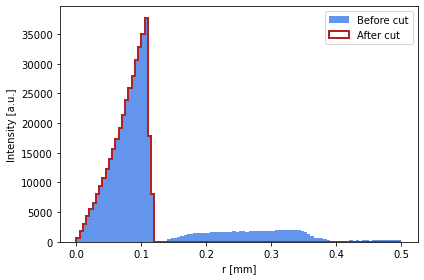

In [100]:
_, bins, _ = plt.hist(df_sim["r_exit"], bins = 100, range = [0, 0.5], 
                      color = "cornflowerblue", 
                      label = "Before cut")

df_sim = df_sim.drop(df_sim[df_sim.r_exit > 0.125].index)

plt.hist(df_sim["r_exit"], bins = bins, color = "firebrick", label = "After cut", histtype = "step", lw = 2);

plt.xlabel("r [mm]")
plt.ylabel("Intensity [a.u.]")
plt.legend();
plt.tight_layout();

In [101]:
print(len(df_sim))
df_sim = df_sim.drop(df_sim[df_sim["rayleighScatterings"] > 0].index)
print(len(df_sim))

389652
379465


In [102]:
df_sim["inCladding"] = df_sim["r_exit"] > 0.11
df_sim["Theta"] = np.arccos(df_sim["px_start"])/np.pi*180

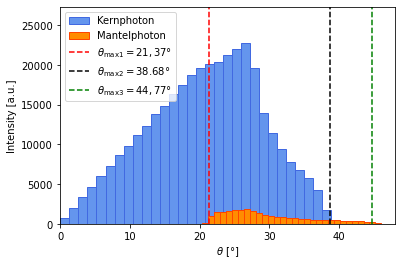

In [103]:
counts, bins, _ = plt.hist(df_sim["Theta"][df_sim["inCladding"] == False], 
                           bins = 30, label = "Kernphoton", color = "cornflowerblue", edgecolor = "royalblue")
_, bins, _ = plt.hist(df_sim["Theta"][df_sim["inCladding"] == True], 
                      bins = 30, label = "Mantelphoton", color = "darkorange", edgecolor = "orangered")
plt.vlines(21.37, 0, 1.2*max(counts), color = "red", ls = "dashed", label = r"$\theta_{\mathrm{max}1} = 21,37°$");
plt.vlines(38.68, 0, 1.2*max(counts), color = "black", ls = "dashed", label = r"$\theta_{\mathrm{max}2} = 38.68°$");
plt.vlines(44.77, 0, 1.2*max(counts), color = "green", ls = "dashed", label = r"$\theta_{\mathrm{max}3} = 44,77°$");
plt.xlabel(r"$\theta$ [°]")
plt.ylabel("Intensity [a.u.]")
plt.ylim(0, 1.2*max(counts))
plt.xlim(0, 48)
plt.legend(loc = "upper left");

In [104]:
df_sim.groupby(["inCladding"])["Theta"].max()

inCladding
False    38.907093
True     46.074345
Name: Theta, dtype: float64

In [105]:
# Abstand zum Mittelpunkt (Abstand Gerade-Gerade)

def distance_lineline(v1, v2, p1, p2): # v1, v2, p1, p2 should be numpy arrays
    cross_prod = np.cross(v1, v2)
    if np.all(cross_prod == 0):
        return np.linalg.norm(p1 - p2)
    n = cross_prod / np.linalg.norm(cross_prod)
    return np.abs(np.dot(n, (p1 - p2)))

def r_min(px, py, pz, x, y, z):
    a = np.array([x, y, z])
    p = np.array([px, py, pz])
    return distance_lineline(np.array([1, 0, 0]), p, np.zeros(3), a)


In [106]:
df_sim['r_min'] = df_sim.apply(lambda row: r_min(row['px_start'], row['py_start'], row['pz_start'],
                                                 row['x_start'], row['y_start'], row['z_start']), axis=1)

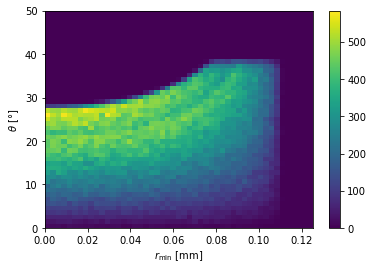

In [107]:
N_bins = 50
h = plt.hist2d(df_sim["r_min"][df_sim["inCladding"] == False],
               df_sim["Theta"][df_sim["inCladding"] == False],
               bins = [np.linspace(0, 0.125, N_bins), np.linspace(0, 50, N_bins)])
plt.colorbar(h[3]);
plt.xlabel(r"$r_\mathrm{min}$ [mm]")
plt.ylabel(r"$\theta$ [°]");

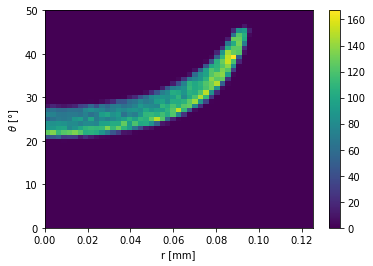

In [108]:
h2 = plt.hist2d(df_sim["r_min"][df_sim["inCladding"] == True],
               df_sim["Theta"][df_sim["inCladding"] == True],
               bins = [h[1], h[2]])
plt.colorbar(h2[3]);
plt.xlabel("r [mm]")
plt.ylabel(r"$\theta$ [°]");

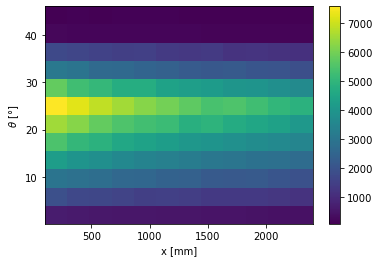

In [113]:
h = plt.hist2d(df_sim["gpsPosX"], df_sim["Theta"], bins = 12)
plt.colorbar(h[3]);
plt.xlabel(r"$x$ [mm]")
plt.ylabel(r"$\theta$ [°]");

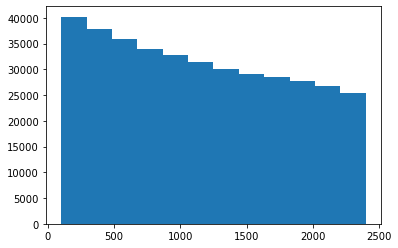

In [110]:
plt.hist(df_sim["gpsPosX"], bins = 12);

In [111]:
df_sim["gpsPosX"].unique()

array([2400., 2300., 2200., 2100., 2000., 1900., 1800., 1700., 1600.,
       1500., 1400., 1300., 1200., 1100., 1000.,  900.,  800.,  700.,
        600.,  500.,  400.,  300.,  200.,  100.])

In [129]:
test = pd.read_csv("content/data/Simulation/dataframe.csv")

In [132]:
test[test["rayleighScatterings"] > 0]

,index,y_exit,z_exit,x_start,y_start,z_start,px_start,py_start,pz_start,reflCoCl,...,wl,gpsPosX,length_core,length_clad,rayleighScatterings,job_nr,r_exit,inCladding,Theta,r_min
77,92,0.070553,0.009014,2400.019043,0.069999,0.032929,0.916163,0.289037,0.277673,1051.0,...,468.623016,2400.0,2270.170898,321.321381,1.0,0,0.071126,False,23.628514,0.024748
79,94,-0.039221,0.073926,2400.005981,-0.051767,0.036219,0.976354,0.215415,0.018118,2983.0,...,503.232910,2400.0,2477.364258,0.000000,1.0,0,0.083686,False,12.484528,0.040430
120,146,-0.022674,-0.075605,2400.037964,-0.059597,-0.065017,0.877456,0.195434,-0.438037,8567.0,...,503.112244,2400.0,2723.215332,0.000000,1.0,0,0.078932,False,28.662974,0.080917
124,150,-0.007071,-0.095279,2400.037476,-0.092822,-0.048473,0.903866,-0.425094,0.048186,4751.0,...,450.167450,2400.0,2551.358643,154.207947,1.0,0,0.095541,False,25.329082,0.058619
129,158,0.016889,0.046248,2400.043945,0.030125,0.054833,0.930349,0.292366,0.221300,644.0,...,574.447144,2400.0,1986.512329,528.122559,1.0,0,0.049235,False,21.510782,0.025540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389422,472837,0.025125,0.059787,100.007080,0.017186,-0.107812,-0.757570,-0.576100,0.306915,1710.0,...,472.473480,100.0,3238.214844,506.635254,1.0,47,0.064852,False,139.250422,0.087071
389466,472889,0.037972,0.006395,99.997681,0.037501,-0.056392,0.986284,0.154235,0.058787,103.0,...,454.921295,100.0,102.149605,0.000000,1.0,47,0.038507,False,9.500653,0.066050
389559,472997,-0.044078,-0.006101,99.998657,-0.084585,-0.038877,-0.944382,-0.237443,-0.227513,2649.0,...,492.399292,100.0,3334.207520,231.694000,1.0,47,0.044498,False,160.801066,0.030449
389573,473014,0.006724,0.071672,112.098511,-0.108049,-0.017191,-0.176093,-0.129629,0.975801,3798.0,...,425.599854,100.0,217.069427,0.000000,1.0,47,0.071987,False,100.142274,0.109372


In [131]:
len(df_sim)

379465

In [ ]:
389652